In [95]:
import numpy as np
from tqdm.notebook import tqdm
from functools import partial

In [1]:
import torch
import clip
from PIL import Image



In [9]:
import matplotlib.pyplot as plt

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [127]:
image = preprocess(Image.open("dog.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat", "a golden retreiver puppy"]).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


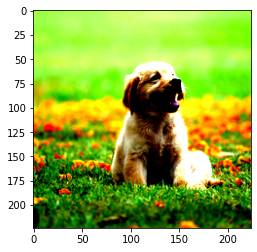

In [128]:
plt.imshow(image[0].permute(1, 2, 0))

In [129]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
image_features.shape, text_features.shape

Label probs: [[1.3679414e-06 7.6230528e-04 3.2884384e-06 9.9923301e-01]]


(torch.Size([1, 512]), torch.Size([4, 512]))

In [130]:
logits_per_image.shape, logits_per_text.shape

(torch.Size([1, 4]), torch.Size([4, 1]))

In [131]:
logits_per_image, logits_per_text

(tensor([[19.1691, 25.4922, 20.0462, 32.6706]]),
 tensor([[19.1691],
         [25.4922],
         [20.0462],
         [32.6706]]))

In [132]:
[(image_features[0]*text_features[i]).sum().item() for i in range(3)]

[25.14478874206543, 32.03294372558594, 24.383710861206055]

In [153]:
a = torch.randn(10)

In [155]:
a.sort().values

tensor([-2.1263, -0.9590, -0.3079, -0.3058, -0.1888, -0.0362,  0.1321,  0.2126,
         0.7630,  1.3204])

  0%|          | 0/1000 [00:00<?, ?it/s]

0.508409, 0.528468, 0.546923


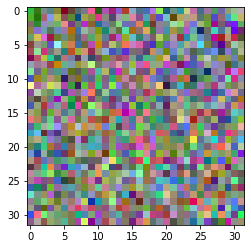

KeyboardInterrupt: 

In [195]:
img_size = (32, 32)

z_target = model.encode_image(preprocess(Image.open("dog.jpg")).unsqueeze(0).to(device))[0]
z_target = z_target/z_target.norm(dim=-1, keepdim=True)
z_target = z_target.detach()

# text = clip.tokenize(["a dog"]).to(device)



def run_ga(pop, fn_fit, fn_mutate, n_gens=10, selection_pressure=0.5):
    
    n_parents = int(len(pop)*selection_pressure)
    
    # npop = torch.zeros_like(pop)
    for i in tqdm(range(n_gens)):
        fit = fn_fit(pop)
        
        idxs_ranked = fit.argsort(dim=-1, descending=True)
        
        elite = pop[idxs_ranked[0]] # directly transfer elite
        parents = pop[idxs_ranked[:n_parents]] # parents
        children = parents[torch.randint(low=0, high=len(parents), size=(len(pop)-1, ))]
        children = fn_mutate(children)
        
        pop = torch.cat([elite[None], children], dim=0)
        
        print(f'{fit.min().item():3.6f}, {fit.mean().item():3.6f}, {fit.max().item():3.6f}')
        if i%10==0:
            x = elite.clamp(0, 255).reshape(*img_size, 3)
            x = x.numpy().astype(np.uint8)
            plt.imshow(x)
            plt.show()
            # x = preprocess(Image.fromarray(x)
        
        
def calc_fitness_clip(pop):
    x = pop.clamp(0, 255).reshape(-1, *img_size, 3)
    x = x.numpy().astype(np.uint8)
    x = torch.stack([preprocess(Image.fromarray(i)) for i in x], dim=0)
    
    
    with torch.no_grad():
        z_images = model.encode_image(x)
    
    z_images = z_images/z_images.norm(dim=-1, keepdim=True)
    
    dot = (z_target[None]@z_images.t())[0]
    return dot.detach()

def mutate(x, sigma=0.1):
    return x+sigma*torch.randn_like(x)
    
    

run_ga(torch.randn(11, *img_size, 3)*50+128,
       fn_fit=calc_fitness_clip, 
       fn_mutate=partial(mutate, sigma=1.),
       n_gens=1000,
       selection_pressure=0.1)
    
    
    

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.27794453501701355


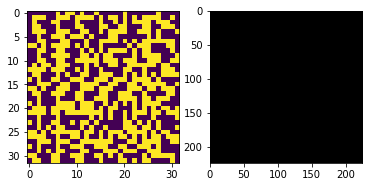

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.39365172386169434


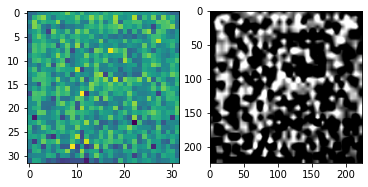

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4304799437522888


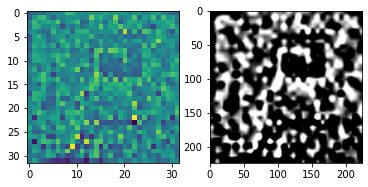

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4519474506378174


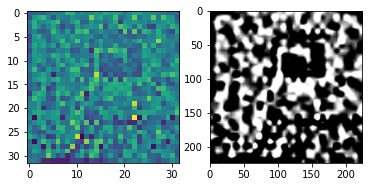

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.46375736594200134


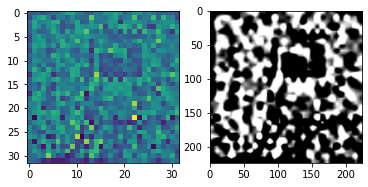

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4755250811576843


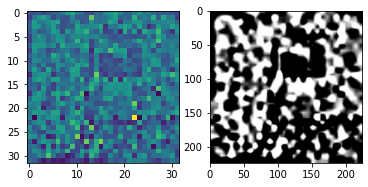

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4831567406654358


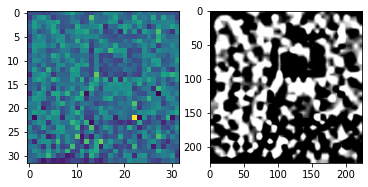

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4872071444988251


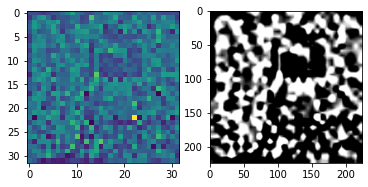

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.49136480689048767


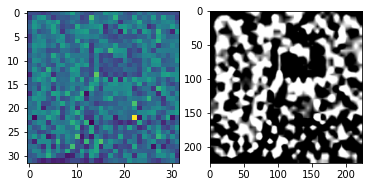

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4837923049926758


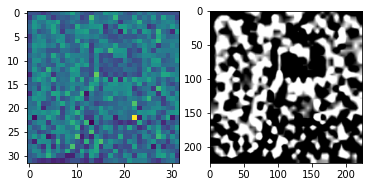

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.4952038526535034


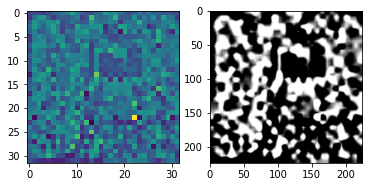

KeyboardInterrupt: 

In [233]:
img = torch.zeros(1, 32, 32).requires_grad_()
# print(img)

opt = torch.optim.Adam([img], lr=1e-1)
opt_model = torch.optim.Adam(model.parameters(), lr=1e-2)

z_target = model.encode_text(clip.tokenize(["a white square"]).to(device))[0].detach()

for i in tqdm(range(1000)):
    
    x = torch.cat([img, img, img], dim=0)
    x = torch.nn.functional.interpolate(x[None], size=(224, 224), mode='bilinear')[0]
    
    z_img = model.encode_image(x[None])[0]
    
    opt_model.zero_grad()
    opt.zero_grad()
    
    loss = -torch.cosine_similarity(z_target, z_img, dim=0)
    loss.backward()
    
    opt.step()
    
    
    
    if i%50==0:
        print(loss.item())
        plt.subplot(121)
        plt.imshow(img.detach().cpu().permute(1, 2, 0).numpy())
        plt.subplot(122)
        plt.imshow(x.detach().cpu().permute(1, 2, 0).numpy())
        plt.show()

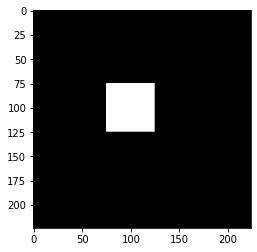

In [245]:
a = torch.zeros(1, 3, 224, 224)
a[:, :, 75:125, 75:125] = 1.


plt.imshow(a[0].permute(1, 2, 0).numpy())



af = model.encode_image(a)[0]
z_target = model.encode_text(clip.tokenize(["a picture of a white square"]).to(device))[0].detach()





In [246]:
torch.cosine_similarity(af, z_target, dim=0)

tensor(0.3253, grad_fn=<DivBackward0>)

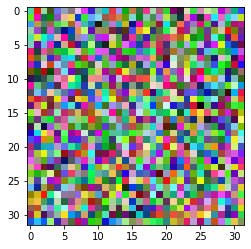

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


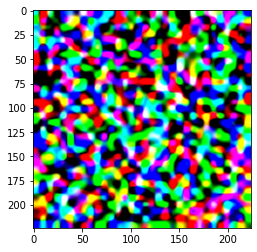

In [212]:
a = np.random.randint(0, 255, size=(32, 32, 3), dtype=np.uint8)
plt.imshow(a)

plt.show()


a = preprocess(Image.fromarray(a))
plt.imshow(a.permute(1, 2, 0).numpy())
plt.show()

# next steps:


regularize the image heavily by creating it from an underlying low dimensional space
an example of this is clipdraw (bezier curves)
or just use like 100 gaussians with xy-centers, amplitudes, and xy-widths and sum them to form a landscape and sample the image from this landscape.
this will enforce the image is low dimesional underneath and maybe will help during optimization.

